## Independent training of classifier on auto-encoder features

In [1]:
%matplotlib inline
import os
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization,\
                         Flatten, Dense, Conv2DTranspose, Reshape,MaxPooling2D, \
                         UpSampling2D, Lambda, Dropout, Concatenate,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pickle
import random
import collections
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(11)
tf.set_random_seed(11)
data_path = "cifar-10-batches-py"


# *Read Data*

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        datadict = pickle.load(fo, encoding='bytes')
    return datadict

In [3]:
label_path = os.path.join(data_path,'batches.meta')
label_dict = unpickle(label_path) 
class_list_b = label_dict[b'label_names']
cut_factor = 0.5
bird = 2
deer = 4
truck = 9
downsample_list = [2,4,9]
class_list=[]
for each in class_list_b:
    class_list.append(each.decode('utf8'))

In [4]:
def load_train_data(data_path):
    for i in range(1,6):
        batch_path = os.path.join(data_path, 'data_batch_' + str(i))
        data_dict = unpickle(batch_path)
        #d =collections.Counter(data_dict[b'labels'])
        #dd = collections.OrderedDict(sorted(d.items(), key=lambda t: t[0]))
        #print(d)
        #print(dd)
        if (i == 1):
            train_data = data_dict[b'data']
            train_labels = data_dict[b'labels']
            
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
            train_labels += data_dict[b'labels']
    
    
    train_data = train_data.reshape((len(train_data),3,32, 32))
    train_data = train_data.transpose(0, 2, 3, 1)
    train_labels = np.asarray(train_labels)
    
    data_dict = unpickle(data_path+"/test_batch")
    test_data = np.asarray(data_dict[b'data'])
    test_labels = np.asarray(data_dict[b'labels'])
    
    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = test_data.transpose(0, 2, 3, 1)
    return train_data,train_labels,test_data,test_labels

def downsample_data(downsample_list,Xtrain,Ytrain,cut_factor):
    for i,class_id in enumerate(downsample_list):
        label_idx = [idx for idx, y in enumerate(Ytrain) if y == class_id]
        if (i == 0):
            downsample_ids = random.sample(label_idx,(int)(cut_factor*len(label_idx)))
        else:
            downsample_ids += random.sample(label_idx,(int)(cut_factor*len(label_idx)))
    downsample_ids = sorted(downsample_ids)
    new_Xtrain = np.delete(Xtrain,downsample_ids,axis=0)
    new_Ytrain = np.delete(Ytrain,downsample_ids,axis=0)
    return new_Xtrain,new_Ytrain    

full_Xtrain,full_Ytrain,Xtest,Ytest = load_train_data(data_path)
Xtrain,Ytrain = downsample_data(downsample_list,full_Xtrain,full_Ytrain,cut_factor)
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

num_training_imgs = Xtrain.shape[0]
num_test_imgs = Xtest.shape[0]
num_classes = len(np.unique(Ytrain))

print(num_classes,num_training_imgs,num_test_imgs)

YtrainHot = keras.utils.to_categorical(Ytrain, num_classes)
YtestHot = keras.utils.to_categorical(Ytest, num_classes)


(42500, 32, 32, 3)
(42500,)
(10000, 32, 32, 3)
(10000,)
10 42500 10000


In [5]:
Xtrain = Xtrain.astype('float32')/255.
Xtest = Xtest.astype('float32')/255.

# # mean-subtraction
# Xtrain_mean = np.mean(Xtrain, axis=(0))
# Xtrain -= Xtrain_mean
# Xtest -= Xtrain_mean

###standardization

# Xtrain_mean = np.mean(Xtrain,axis=(0,1,2))
# std = np.std(Xtrain,axis=(0,1,2))
# Xtrain = Xtrain/(std+1e-7)
# Xtest = Xtest/(std+1e-7)
# print(Xtrain_mean)
# print(std)
num_classes = 10

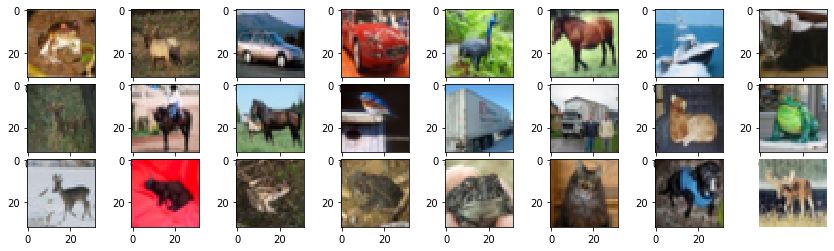

In [8]:
def check_images(images):
    fig = plt.figure(figsize=(15, 4))
    columns = 8
    rows = 3
    for i in range(1, columns*rows+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
    
    fig.subplots_adjust(hspace=0.1)
    fig.subplots_adjust(wspace=0)
    plt.axis('off')
    #plt.tight_layout()
    plt.show()
    
check_images(Xtrain)

# Evaluation functions

In [6]:
def visualize_reconstruction(ip, dec, num=10):
    n = num
    plt.figure(figsize=(20, 4))
    mse = np.mean(((ip.astype("float") - dec.astype("float"))**2),axis=(0,1,2,3))
    print(mse)   
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(ip[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def evaluate_classification(Ytest,Ypred):
    cm=confusion_matrix(Ytest, Ypred)
    print("Classification Report:\n")
    cr=classification_report(Ytest,Ypred,target_names=class_list)
    print(cr)
    plt.figure(figsize=(12,12))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels = class_list, yticklabels = class_list, fmt="d")

# *Autoencoder: definition*

### With Upsampling in decoder

In [10]:
def ae_model1():
    input_img = Input(shape=(32, 32, 3))
    conv1 = Conv2D(64, (3, 3),strides=(2,2), activation = 'relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1) #16
    conv2 = Conv2D(32, (3, 3), strides = (2,2),activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2) #8
    encoded = conv2
    conv3 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(encoded)
    conv3 = BatchNormalization()(conv3)  #8
    conv3 = UpSampling2D((2, 2))(conv3) #16                 #16x16x32
    conv4 = Conv2D(64, (3, 3),activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(3, (3, 3), padding='same')(conv4)          #32x32x3
    conv5 = BatchNormalization()(conv5)
    decoded = Activation('sigmoid',name='decoder')(conv5)  
    
    model = Model(inputs=input_img, outputs=decoded)

    return model


### With convolution transpose with strides of 2 in decoder

In [11]:
def ae_model():
    
    input_img = Input(shape=(32, 32, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2p = MaxPooling2D(pool_size=(2, 2))(conv2) #16
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2p)
    conv3 = BatchNormalization()(conv3)
    
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4p = MaxPooling2D(pool_size=(2, 2),name='encoder')(conv4)   #8

    enc_opt = conv4p
    flatten_opt = Flatten(name = 'flatten')(conv4p)
    enc_opt = Reshape((8, 8, 64))(flatten_opt)
    
    #conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4p)
    #conv5 = BatchNormalization()(conv5)
    #enc_opt = conv5    
        
    convt6 = Conv2DTranspose(64, kernel_size=2, strides=2)(enc_opt)
    convt6 = BatchNormalization()(convt6)
    
    convt7 = Conv2DTranspose(32, kernel_size=2, strides=2)(convt6)
    convt7 = BatchNormalization()(convt7)
    
    conv8 = Conv2D(32,(2,2),activation='relu', padding='same')(convt7)
    
    # reconstruction
    dec_opt = Conv2D(3,(1,1),activation = 'sigmoid',name='decoder')(conv8)
        
    model = Model(inputs=input_img, outputs=dec_opt)

    return model


# *Autoencoder: training*

Train on 42500 samples, validate on 10000 samples
Epoch 1/50
42500/42500 [==============================] - 12s 274us/sample - loss: 0.0074 - val_loss: 0.0188
Epoch 2/50
42500/42500 [==============================] - 8s 198us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 3/50
42500/42500 [==============================] - 9s 201us/sample - loss: 0.0025 - val_loss: 0.0063
Epoch 4/50
42500/42500 [==============================] - 9s 202us/sample - loss: 0.0022 - val_loss: 0.0034
Epoch 5/50
42500/42500 [==============================] - 8s 198us/sample - loss: 0.0020 - val_loss: 0.0019
Epoch 6/50
42500/42500 [==============================] - 9s 202us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 7/50
42500/42500 [==============================] - 8s 197us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
42500/42500 [==============================] - 9s 200us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 9/50
42500/42500 [==============================] - 9s 201us/sample - loss: 0.0

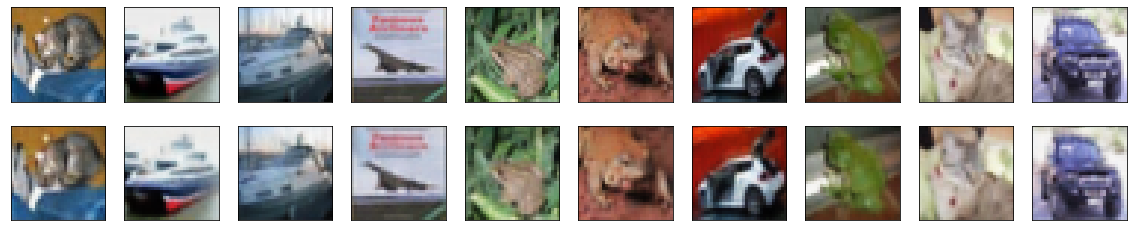

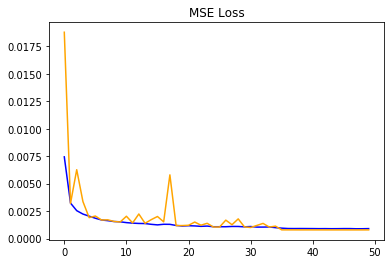

In [12]:
ae_model = ae_model()
opt = Adam()
ae_model.compile(loss='mean_squared_error',
                  optimizer=opt)
estop_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,verbose=1)
lrdecay_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, min_delta=0.0001, verbose=1)
callbacks = [lrdecay_callback, estop_callback]

history = ae_model.fit(Xtrain,Xtrain,
           validation_data=(Xtest,Xtest),
           batch_size=128,
           epochs=50, callbacks = callbacks,
           shuffle=True)

ae_model.save('ae_model.h5')


encoder_model = Model(inputs=ae_model.inputs,
                                 outputs=ae_model.get_layer('encoder').output)
flatten_opt = Model(inputs=ae_model.inputs,
                                 outputs=ae_model.get_layer('flatten').output)

pred_imgs = ae_model.predict(Xtest)
visualize_reconstruction(Xtest,pred_imgs)


plt.title('MSE Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()


### Feature plot  - PCA , TSNE on some samples 

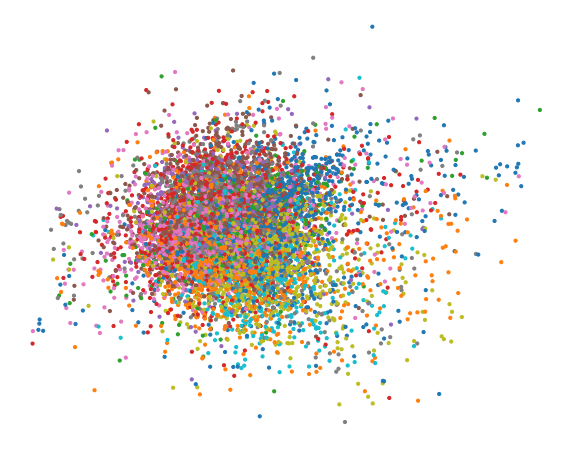

In [13]:
flatten_opt = Model(inputs=ae_model.inputs,
                                 outputs=ae_model.get_layer('flatten').output)
enc_train_features = flatten_opt.predict(Xtrain[100:10100,:,:,:])

#pca plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(enc_train_features)
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=Ytrain[100:10100],s=10, cmap=cmap)
plt.axis("off")
#plt.colorbar()
plt.show()

# *Autoencoder: features*

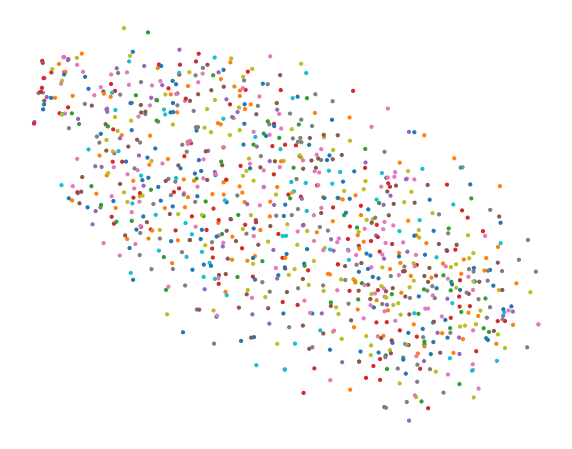

In [14]:
tsne = TSNE().fit_transform(enc_train_features[100:1100])
y = Ytrain[100:1100]
tsne[:,0] = (tsne[:,0]-np.min(tsne[:,0])) / (np.max(tsne[:,0]) - np.min(tsne[:,0]))
tsne[:,1] = (tsne[:,1]-np.min(tsne[:,1])) / (np.max(tsne[:,1]) - np.min(tsne[:,1]))

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(tsne[:,0], tsne[:,1], c=Ytrain[100:1100], s=10, cmap=cmap)
plt.axis("off")
#plt.colorbar()
plt.show()


In [15]:
def classification_model():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(8, 8, 64)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
#     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#     model.add(BatchNormalization())
#     #model.add(Dropout(0.2))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',activity_regularizer=l2(0.00001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform',activity_regularizer=l2(0.00005)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model


In [56]:
cmodel = classification_model()
#opt = SGD(lr=0.001, momentum=0.9)
opt = Adam()
cmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
           

train_datagen = ImageDataGenerator(shear_range=0.1,rescale=1./255,rotation_range=20, zoom_range=0.2, brightness_range=[0.3,0.7],
                                   width_shift_range=0.1, height_shift_range=0.2, horizontal_flip=True,
                                   vertical_flip=True, fill_mode="nearest")

test_datagen = ImageDataGenerator() 
              
def data_generator(train_datagen,Xtrain,YtrainHot,batchsize):
    train_gen = train_datagen.flow(Xtrain, YtrainHot, batch_size=batchsize)
    while(True):
        Xtrain_data, Ytrain_data = train_gen.next()
        Xtrain_features = encoder_model.predict(Xtrain_data)
        yield(Xtrain_features, Ytrain_data)
     
batch_size = 64
Xtrain_features = encoder_model.predict(Xtrain)
Xtest_features = encoder_model.predict(Xtest)
steps = int(Xtrain.shape[0] / batch_size)

mcp_callback = ModelCheckpoint('cmodel-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto') 
estop_callback = EarlyStopping(monitor='val_acc', patience=20, min_delta=0.001, restore_best_weights=True)
lrdecay_callback = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=10, min_delta=0.005,min_lr=0.00001,verbose=1)
callbacks = [lrdecay_callback, estop_callback] #, mcp_callback]

history_c = cmodel.fit(Xtrain_features,
           YtrainHot,
           validation_data=(Xtest_features, YtestHot),
           batch_size=64,
           epochs=300,callbacks = callbacks,
           shuffle=True)

# history_c = cmodel.fit_generator(
#         data_generator(train_datagen,Xtrain,YtrainHot,128),
#         steps_per_epoch=steps,
#         epochs=350,
#         shuffle=True, #class_weight=class_weights,
#         validation_data=(Xtest_features,YtestHot))


Train on 42500 samples, validate on 10000 samples
Epoch 1/300
42500/42500 [==============================] - 18s 415us/sample - loss: 1.6935 - acc: 0.4630 - val_loss: 1.3946 - val_acc: 0.5203
Epoch 2/300
42500/42500 [==============================] - 14s 318us/sample - loss: 1.3030 - acc: 0.5715 - val_loss: 1.2551 - val_acc: 0.5837
Epoch 3/300
42500/42500 [==============================] - 12s 284us/sample - loss: 1.1868 - acc: 0.6123 - val_loss: 1.1455 - val_acc: 0.6143
Epoch 4/300
42500/42500 [==============================] - 12s 277us/sample - loss: 1.1110 - acc: 0.6379 - val_loss: 1.1190 - val_acc: 0.6329
Epoch 5/300
42500/42500 [==============================] - 13s 295us/sample - loss: 1.0524 - acc: 0.6626 - val_loss: 1.0667 - val_acc: 0.6471
Epoch 6/300
42500/42500 [==============================] - 12s 275us/sample - loss: 1.0120 - acc: 0.6748 - val_loss: 1.0294 - val_acc: 0.6616
Epoch 7/300
42500/42500 [==============================] - 12s 282us/sample - loss: 0.9325 - acc: 

Epoch 56/300
42500/42500 [==============================] - 12s 277us/sample - loss: 0.1368 - acc: 0.9663 - val_loss: 1.1095 - val_acc: 0.7483
Epoch 57/300
42500/42500 [==============================] - 12s 281us/sample - loss: 0.1382 - acc: 0.9654 - val_loss: 1.1120 - val_acc: 0.7472
Epoch 58/300
42500/42500 [==============================] - 12s 279us/sample - loss: 0.1360 - acc: 0.9664 - val_loss: 1.1091 - val_acc: 0.7486
Epoch 59/300
42500/42500 [==============================] - 12s 282us/sample - loss: 0.1373 - acc: 0.9655 - val_loss: 1.1153 - val_acc: 0.7483
Epoch 60/300
42500/42500 [==============================] - 23s 546us/sample - loss: 0.1383 - acc: 0.9657 - val_loss: 1.1130 - val_acc: 0.7477
Epoch 61/300
42500/42500 [==============================] - 12s 274us/sample - loss: 0.1384 - acc: 0.9652 - val_loss: 1.1166 - val_acc: 0.7480
Epoch 62/300
42500/42500 [==============================] - 12s 278us/sample - loss: 0.1380 - acc: 0.9657 - val_loss: 1.1167 - val_acc: 0.7480

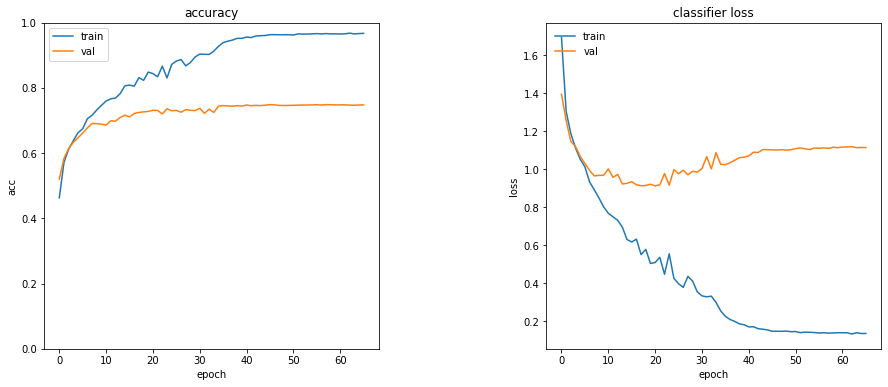

In [57]:
f,ax = plt.subplots(1, 2,figsize=(15,6))
ax[1].plot(history_c.history['loss'],label='train')
ax[1].plot(history_c.history['val_loss'],label='val')
ax[1].set_title('classifier loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='upper left', frameon=False)

ax[0].plot(history_c.history['acc'])
ax[0].plot(history_c.history['val_acc'])
ax[0].set_ylim([0,1])
ax[0].set_title('accuracy')
ax[0].set_ylabel('acc')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

f.subplots_adjust(hspace=0.5)
f.subplots_adjust(wspace=0.5)

plt.show()


In [60]:
cmodel.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_87 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
batch_normalization_88 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 4, 4, 512)       

Classification Report:

              precision    recall  f1-score   support

    airplane       0.72      0.86      0.79      1000
  automobile       0.82      0.90      0.86      1000
        bird       0.73      0.54      0.62      1000
         cat       0.55      0.61      0.58      1000
        deer       0.80      0.60      0.69      1000
         dog       0.61      0.70      0.66      1000
        frog       0.78      0.84      0.81      1000
       horse       0.77      0.83      0.80      1000
        ship       0.87      0.85      0.86      1000
       truck       0.89      0.75      0.81      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



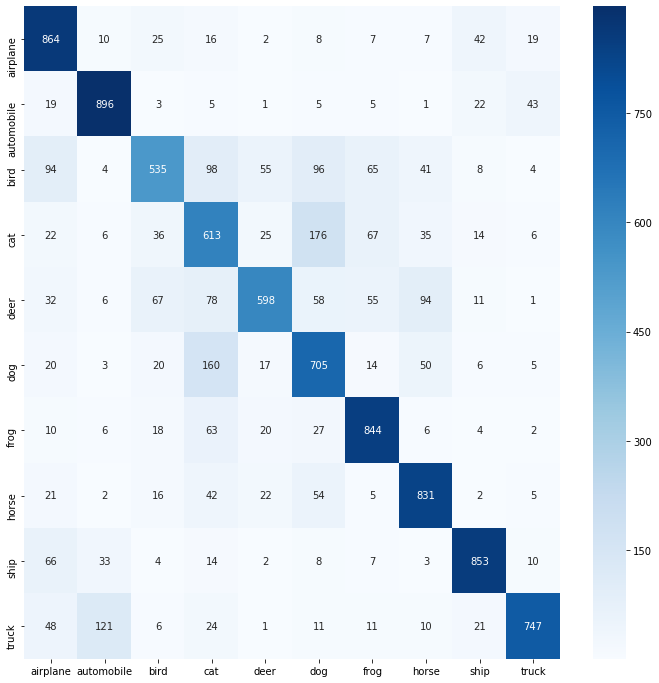

In [58]:
YpredsHot = cmodel.predict(Xtest_features)
Ypreds = np.argmax(YpredsHot,axis=1)
evaluate_classification(Ytest,Ypreds)

## Joint training

In [62]:
def joint_model(): 
    
    input_img = Input(shape=(32, 32, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2p = MaxPooling2D(pool_size=(2, 2))(conv2) #16
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2p)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4p = MaxPooling2D(pool_size=(2, 2),name='encoder')(conv4)   #8

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4p)
    
    enc_opt = conv5
    
    conv6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same') (enc_opt)
    conv6 = Concatenate()([conv6, conv4])
    #conv6 = Dropout(0.05)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6) #16
    conv6 = BatchNormalization()(conv6)

    conv7 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same') (conv6)
    conv7 = Concatenate()([conv7, conv2])   #32
    #conv7 = Dropout(0.05)(conv7)
    con7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)
    conv7 = BatchNormalization()(conv7)

    
#     x = Conv2D(64,(3,3),activation='relu', padding='same')(enc_opt)
#     x = BatchNormalization()(x)
#     x = UpSampling2D((2, 2))(x)   #16
#     x = Conv2D(32,(3,3),activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = UpSampling2D((2, 2))(x) #32
#     #x = Conv2D(32,(3,3),activation='relu', padding='same')(x)
#     #x = BatchNormalization()(x)    
    
    #x = Conv2DTranspose(64, kernel_size=2, strides=2)(enc_opt)
    #x = Conv2DTranspose(32, kernel_size=2, strides=2)(x)
    
    # reconstruction
    dec_opt = Conv2D(3,(1,1),activation='sigmoid',name='decoder')(conv7)
    
    #classification 
#     c = Conv2D(1024, 3, padding="same")(middle)
#     c = Activation('relu')(c)
#     c = BatchNormalization()(c)
#     c = MaxPool2D(2)(c)
#     c = Dropout(0.5)(c)
#     c = Conv2D(128, 3, padding="same")(c)
#     c = Activation('relu')(c)
#     c = BatchNormalization()(c)
#     c = MaxPool2D(2)(c)
#     c = Dropout(0.4)(c)
#     c = Flatten()(c)
#     c = Dense(512, activation='relu')(c)
#     c = Dropout(0.35)(c)
#     c = Dense(100, activation='relu')(c)
#     c = Dropout(0.69)(c)
#     classify = Dense(10, activation='softmax', name='classification')(c)

    c = Conv2D(32, (3, 3), activation='relu',padding='same')(enc_opt)
    #c = BatchNormalization()(c)
    c = Conv2D(32, (3, 3), activation='relu')(c)
    c = BatchNormalization()(c)
    c = MaxPooling2D((2, 2))(c)
    #c = Dropout(0.25)(c)
    c = Conv2D(64, (3, 3), activation='relu',padding='same')(c)
    #c = BatchNormalization()(c)
    c = Conv2D(64, (3, 3), activation='relu',padding='same')(c)
    c = BatchNormalization()(c)
    c = MaxPooling2D((2, 2))(c)
    #c = Dropout(0.25)(c)
    #c = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c)
    #c = BatchNormalization()(c)
    c = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c)
    c = BatchNormalization()(c)
    c = MaxPooling2D((2, 2))(c)
    #c = Dropout(0.4)(c)
    c = GlobalAveragePooling2D()(c)
    c = Flatten()(c)
    #c = Dense(512, activation='relu')(c)
    
    #c = BatchNormalization()(c)
    #c = Dropout(0.5)(c)
    classification = Dense(10, activation='softmax',name = 'classifier')(c)
    return Model(inputs = input_img, outputs = [dec_opt, classification])

In [58]:
def aec_model():
    
    input_img = Input(shape=(32, 32, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='c1')(input_img)
    conv1 = BatchNormalization()(conv1)
    
    conv2 = Conv2D(32, kernel_size=3, activation='relu', padding='same',name = 'c2')(conv1)
    conv2 = BatchNormalization(name = 'c2bn')(conv2)
    conv2p = MaxPooling2D(pool_size=(2, 2))(conv2) #16
    
    conv3 = Conv2D(64,kernel_size=3, activation='relu', padding='same', name = 'c3')(conv2p)
    conv3 = BatchNormalization()(conv3)
    
    conv4 = Conv2D(64,kernel_size=3, activation='relu', padding='same', name = 'c4')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4p = MaxPooling2D(pool_size=(2, 2),name='encoder')(conv4)   #8

    enc_opt = conv4p
    flatten_opt = Flatten(name = 'flatten_enc')(conv4p)
    enc_opt = Reshape((8, 8, 64))(flatten_opt)
    
    #conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4p)
    #conv5 = BatchNormalization()(conv5)
    #enc_opt = conv5
        
    convt6 = Conv2DTranspose(64, kernel_size=2, strides=2)(enc_opt)
    convt6 = BatchNormalization()(convt6)
    
    #convtcat6 = Concatenate()([convt6, conv4])
    
    conv6 = Conv2D(64,kernel_size=3, activation='relu', padding='same', name = 'c4d')(convt6)
    conv6 = BatchNormalization()(conv6)
    
    #print(convtcat6)
    convt7 = Conv2DTranspose(32, kernel_size=2, strides=2)(conv6)
    convt7 = BatchNormalization()(convt7)
    #convtcat7 = Concatenate()([convt7, conv2])
    #print(convtcat7)
    conv8 = Conv2D(32,kernel_size=2,activation='relu', padding='same')(convt7)
    
    # reconstruction
    dec_opt = Conv2D(3,kernel_size =1,activation = 'sigmoid',name='decoder')(conv8)
    
    conv= Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name = 'cb_1')(enc_opt)
    conv = BatchNormalization(name = 'cbn_1')(conv)
    conv = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',name='cb_2')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D((2, 2))(conv)
    conv = Dropout(0.2)(conv)
    conv = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',name = 'cb_4')(conv)
    conv = BatchNormalization()(conv)
    #conv = MaxPooling2D((2, 2))(conv)
    conv = Dropout(0.2)(conv)
    conv = GlobalAveragePooling2D()(conv)
    classification = Flatten()(conv)
    classification = Dense(128, activation='relu', kernel_initializer='he_uniform',activity_regularizer=l2(0.00005))(classification)
    classification = BatchNormalization()(classification)
    classification = Dropout(0.5)(classification)
    classification = Dense(10, activation='softmax',name='classifier')(classification)
                        
    
    return Model(inputs = input_img, outputs = [dec_opt, classification])
    

In [59]:
aec_model = aec_model()
opt = Adam()
#opt= SGD(lr= 0.001, momentum= 0.9)

aec_model.compile(loss = {'decoder': 'mean_squared_error','classifier': 'categorical_crossentropy'}, 
                  loss_weights = {'decoder': 0.1, 'classifier': 1.0}, 
                  optimizer = opt,
                  metrics = {'classifier': ['accuracy'], 'decoder': []})


train_datagen = ImageDataGenerator(shear_range=0.1,rescale=1./255,rotation_range=20, brightness_range=[0.2,0.7],
                                   width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,
                                   vertical_flip=True, fill_mode="nearest")#,preprocessing_function=get_random_eraser(v_l=0, v_h=1))

test_datagen = ImageDataGenerator() 


def image_generator(datagen,Xtrain,Ytrain,batchsize):
    gen = datagen.flow(Xtrain, Ytrain, batch_size=batchsize)
    while(True):
        Xtrain_data, Ytrain_data = gen.next()
        yield Xtrain_data, {'decoder': Xtrain_data,'classifier': Ytrain_data}
     
#mcp_callback_j = ModelCheckpoint('aug_cmodel-{epoch:03d}-{classifier_acc:03f}-{val_classifier_acc:03f}.h5', verbose=1, monitor='val_classifier_acc',save_best_only=True, mode='auto') 
estop_callback_j = EarlyStopping(monitor='val_classifier_acc', patience=20, min_delta=0.0005, restore_best_weights=True,verbose=1)
lrdecay_callback_j = ReduceLROnPlateau(monitor='val_classifier_acc', factor=0.1, patience=20, min_delta=0.0005,min_lr=0.00001,verbose=1)
callbacks = [lrdecay_callback_j, estop_callback_j]#, mcp_callback_j]


# history = aec_model.fit(Xtrain, [Xtrain,YtrainHot], batch_size=batch_size, epochs=200, 
#                           validation_data = (Xtest, [Xtest,YtestHot]),
#                           shuffle=True)
# #                           class_weight=class_weights
batch_size = 64
steps = Xtrain.shape[0]//batch_size
# for i in range(100):
#     gen = train_datagen.flow(Xtrain, YtrainHot, batch_size=batch_size)
#     Xtrain_data, Ytrain_data = gen.next()
#     print(Xtrain_data.shape)
#     print(Ytrain_data.shape)

# history = aec_model.fit(Xtrain,{'decoder': Xtrain,'classifier': YtrainHot},
#         epochs=150,callbacks = callbacks,
#         shuffle=True, #class_weight=class_weights,
#         validation_data=(Xtest,{'decoder': Xtest,'classifier': YtestHot}))



history = aec_model.fit_generator(
        image_generator(train_datagen,Xtrain,YtrainHot,batch_size),
        steps_per_epoch=steps,
        epochs=300, #class_weight={'decoder': class_weights,'classifier': class_weights}, 
        shuffle=True, callbacks=callbacks,
        validation_data=(Xtest,{'decoder': Xtest,'classifier': YtestHot}))


Epoch 1/300
664/664 [==============================] - 63s 94ms/step - loss: 1.8656 - decoder_loss: 0.0058 - classifier_loss: 1.8503 - classifier_acc: 0.3658 - val_loss: 2329.5850 - val_decoder_loss: 18631.7480 - val_classifier_loss: 150.5133 - val_classifier_acc: 0.2040
Epoch 2/300
165/664 [======>.......................] - ETA: 32s - loss: 1.4819 - decoder_loss: 0.0048 - classifier_loss: 1.4699 - classifier_acc: 0.4733

KeyboardInterrupt: 

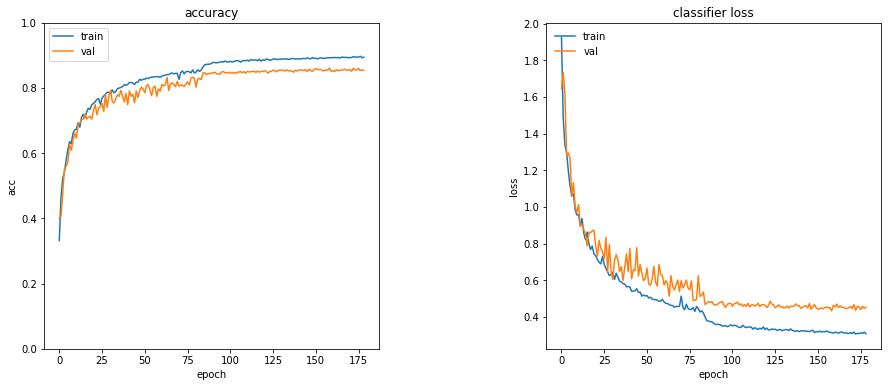

In [52]:
#%tensorboard --logdir logs/
f,ax = plt.subplots(1, 2,figsize=(15,6))
ax[1].plot(history.history['classifier_loss'],label='train')
ax[1].plot(history.history['val_classifier_loss'],label='val')
ax[1].set_title('classifier loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='upper left', frameon=False)

ax[0].plot(history.history['classifier_acc'])
ax[0].plot(history.history['val_classifier_acc'])
ax[0].set_ylim([0,1])
ax[0].set_title('accuracy')
ax[0].set_ylabel('acc')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

f.subplots_adjust(hspace=0.5)
f.subplots_adjust(wspace=0.5)

plt.show()

aec_model = load_model('aug_cmodel-159-0.892214-0.860400.h5')
# YpredsHot = aec_model.predict(Xtest)
# Ypreds = np.argmax(YpredsHot,axis=1)
# evaluate_classification(Ytest,Ypreds)



0.014670171690930463


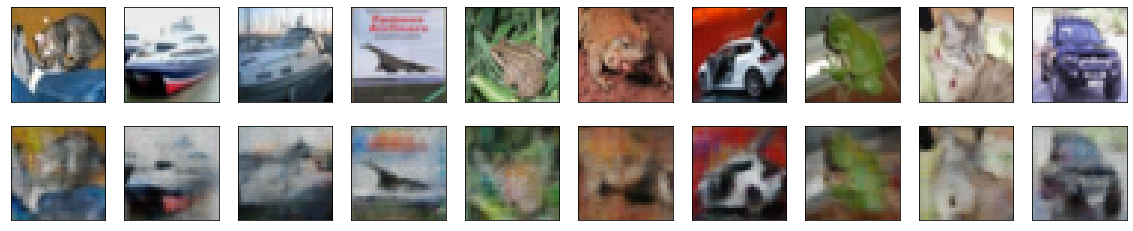

Classification Report:

              precision    recall  f1-score   support

    airplane       0.87      0.91      0.89      1000
  automobile       0.88      0.97      0.92      1000
        bird       0.81      0.80      0.80      1000
         cat       0.76      0.73      0.74      1000
        deer       0.88      0.79      0.83      1000
         dog       0.86      0.76      0.80      1000
        frog       0.81      0.95      0.87      1000
       horse       0.89      0.92      0.90      1000
        ship       0.92      0.91      0.92      1000
       truck       0.94      0.87      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



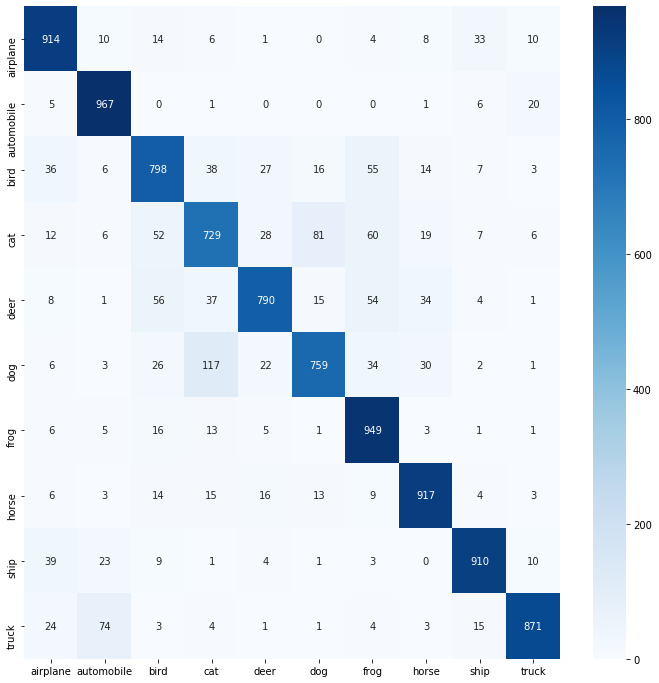

In [53]:
recons_imgs, YpredsHot = aec_model.predict(Xtest)
Ypreds = np.argmax(YpredsHot,axis=1)
visualize_reconstruction(Xtest,recons_imgs)
evaluate_classification(Ytest,Ypreds)

In [54]:
aec_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
c1 (Conv2D)                     (None, 32, 32, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 32, 32, 32)   128         c1[0][0]                         
__________________________________________________________________________________________________
c2 (Conv2D)                     (None, 32, 32, 32)   9248        batch_normalization_89[0][0]     
___________________________________________________________________________________________

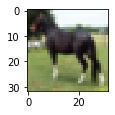

In [55]:
ip_img = Xtest[4100,...]
plt.figure(figsize=(1.5,1.5))
plt.imshow(ip_img)

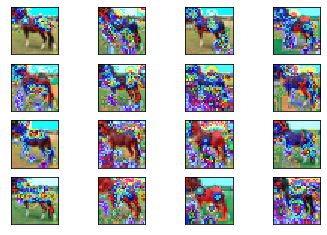

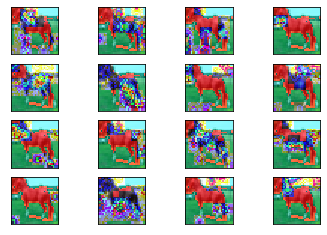

In [56]:
import cv2
ixs = [10,15] #layer indices - encoder layer(name = encoder) and after first layer of classification (name = cbn_1)
img1 = ip_img
img = np.expand_dims(ip_img, axis=0)
outputs = [aec_model.layers[i].output for i in ixs]
model = Model(inputs=aec_model.inputs, outputs=outputs)
feature_maps = model.predict(img)
square = 4
for fmap in feature_maps:
# plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            filter_i= fmap[0, :, :, ix-1]/fmap[0, :, :, ix-1].max()
            #plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            fmap1 = cv2.resize(filter_i,(32,32))
            fmap1 = cv2.applyColorMap(np.uint8(255 * (255 - fmap1)), cv2.COLORMAP_JET)
            #print(fmap1.shape)
#             for each in range(ip_img.shape[2]):
#                 ip_img[:,:,each] = np.multiply(ip_img[:,:,each],fmap1)
            plt.imshow(((fmap1 * 0.4 + ip_img)*255).astype(np.uint8))
            ix += 1
    # show the figure
    plt.show()
